In [14]:
import sys
import rasterio
from datetime import datetime
import time
from pvlib import solarposition
sys.path.append('/home/potzschf/repos/')
from helperToolz.helpsters import *
from helperToolz.guzinski import * 

name_list = ['maxLST', 'minVZA', 'readable', 'order']


In [22]:
tiles = [file.split('SLOPE_')[-1].split('.')[0] for file in getFilelist('/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/SLOPE/', '.tif')]
comp = 'maxLST'


year = 2019
tile = 'X0052_Y0051'

slope_path = f'/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/SLOPE/SLOPE_{tile}.tif'
aspect_path = f'/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/ASPECT/ASPECT_{tile}.tif'
dem_path = f'/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/DEM/DEM_{tile}.tif'
lat_path = f'/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/LAT/Latitude_{tile}.tif'
lon_path = f'/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/LON/Longitude_{tile}.tif'
acq_times = getFilelist(f'/data/Aldhani/eoagritwin/et/Sentinel3/LST/LST_values/Acq_time/int_format/{year}', '.tif')
acq_time_list = [file for file in acq_times if not any(substr in file for substr in [nam for nam in name_list if nam != comp])]
stor_dir = f'/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/INCIDENCE3/{comp}/{tile}/{year}/'

os.makedirs(stor_dir, exist_ok=True)

    # load all data and convert if needed
with rasterio.open(slope_path) as slope_src:
    slope = slope_src.read(1)  # Read first band
    
with rasterio.open(aspect_path) as aspect_src:
    aspect = aspect_src.read(1)

with rasterio.open(lon_path) as lon_src:
    lon = lon_src.read(1)

with rasterio.open(lat_path) as lat_src:
    lat = lat_src.read(1)

with rasterio.open(dem_path) as dem_src:
    dem = dem_src.read(1)

# Replace no data or negative values with nan if needed
slope = np.where(slope < 0, np.nan, slope)
aspect = np.where(aspect < 0, np.nan, aspect)

# Convert degrees to radians for trigonometric calculations
slope_rad = np.deg2rad(slope)
aspect_rad = np.deg2rad(aspect)

In [25]:
file = acq_time_list[0]
month = 'April'
              
# warp S3 dates into tile and read-in
warped_ds = warp_raster_to_reference(file, reference_path=slope_path, output_path='MEM', resampling='near')
days = warped_ds.RasterCount
                            
time_warp = warped_ds.GetRasterBand(5).ReadAsArray()
try:
    time_warp_intpol = interpol_Time(time_warp)
except:
    time_warp_intpol = time_warp

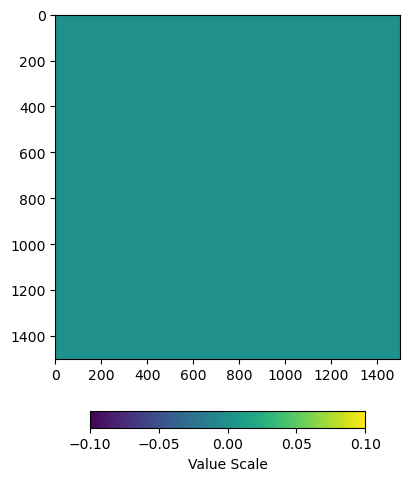

In [26]:
plotter(time_warp)

In [ ]:

# flatten
time_flat = time_warp.ravel()
lat_flat = lat.ravel()
lon_flat = lon.ravel()
dem_flat = dem.ravel()
shape = time_warp.shape

# convert to tz-aware datetimes (assume unix seconds UTC)
times = pd.to_datetime(time_flat, unit='s', utc=True)

# handle nodata times (e.g. <= 0) -> mask them
valid_time_mask = ~np.isnan(time_flat) & (time_flat > 0)

incidence_flat = np.full(time_flat.shape, np.nan, dtype=np.float32)

In [ ]:
unique_times, inverse_idx = np.unique(times[valid_time_mask], return_inverse=True)

In [ ]:
valid_indices = np.nonzero(valid_time_mask)[0] 

In [ ]:
for ut_i, ut in enumerate(unique_times):
    # indices (in flattened arrays) that correspond to this unique time
    sel = valid_indices[inverse_idx == ut_i]

In [ ]:
# speed: compute solar position grouped by unique timestamps that actually occur
unique_times, inverse_idx = np.unique(times[valid_time_mask], return_inverse=True)
# For each unique time, compute solar position for all valid pixels with that time.
# Note: pvlib accepts vectorized latitude/longitude arrays of same length as lat/lon slice.
# We'll iterate unique times (usually few) — cheaper than computing per-pixel if timestamps repeat.
valid_indices = np.nonzero(valid_time_mask)[0]  # indices in flattened arrays

for ut_i, ut in enumerate(unique_times):
    # indices (in flattened arrays) that correspond to this unique time
    sel = valid_indices[inverse_idx == ut_i]
    if sel.size == 0:
        continue

    sel_lat = lat_flat[sel]
    sel_lon = lon_flat[sel]
    sel_dem = dem_flat[sel]

    # compute solar position for these points at single time (pvlib will vectorize lat/lon)
    sp = solarposition.get_solarposition(time=ut, latitude=sel_lat, longitude=sel_lon, altitude=sel_dem)


In [ ]:
tiles = [file.split('SLOPE_')[-1].split('.')[0] for file in getFilelist('/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/SLOPE/', '.tif')]


comp = 'maxLST'


for year in [2019]:# range(2017, 2025, 1):
    for tile in tiles:
        if tile != 'X0073_Y0047':
            continue
        # File paths for slope and aspect rasters (in degrees)
        slope_path = f'/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/SLOPE/SLOPE_{tile}.tif'
        aspect_path = f'/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/ASPECT/ASPECT_{tile}.tif'
        dem_path = f'/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/DEM/DEM_{tile}.tif'
        lat_path = f'/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/LAT/Latitude_{tile}.tif'
        lon_path = f'/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/LON/Longitude_{tile}.tif'
        acq_times = getFilelist(f'/data/Aldhani/eoagritwin/et/Sentinel3/LST/LST_values/Acq_time/int_format/{year}', '.tif')
        acq_time_list = [file for file in acq_times if not any(substr in file for substr in [nam for nam in name_list if nam != comp])]
        stor_dir = f'/data/Aldhani/eoagritwin/et/Auxiliary/DEM/Force_Tiles/INCIDENCE3/{comp}/{tile}/{year}/'

        os.makedirs(stor_dir, exist_ok=True)

         # load all data and convert if needed
        with rasterio.open(slope_path) as slope_src:
            slope = slope_src.read(1)  # Read first band
            
        with rasterio.open(aspect_path) as aspect_src:
            aspect = aspect_src.read(1)

        with rasterio.open(lon_path) as lon_src:
            lon = lon_src.read(1)

        with rasterio.open(lat_path) as lat_src:
            lat = lat_src.read(1)

        with rasterio.open(dem_path) as dem_src:
            dem = dem_src.read(1)

        # Replace no data or negative values with nan if needed
        slope = np.where(slope < 0, np.nan, slope)
        aspect = np.where(aspect < 0, np.nan, aspect)

        # Convert degrees to radians for trigonometric calculations
        slope_rad = np.deg2rad(slope)
        aspect_rad = np.deg2rad(aspect)
        
        for file in acq_time_list:
            month = file.split('.tif')[0].split('_')[-1]
            if month in ['April', 'May', 'June', 'July', 'August', 'September', 'October']:
               
                if month != 'July':
                    continue
                # warp S3 dates into tile and read-in
                warped_ds = warp_raster_to_reference(file, reference_path=slope_path, output_path='MEM', resampling='near')
                days = warped_ds.RasterCount

                for day in range(days):
                    if os.path.exists(f'{stor_dir}INCIDENCE_{tile}_{year}_{month}_{(day+1):02d}.tif'):
                        t = time.localtime()
                        ti = time.strftime("%H:%M:%S", t)
                        print(f"already exists - next one at {ti}")
                    else:
                        try:
                            
                            time_warp = warped_ds.GetRasterBand(day+1).ReadAsArray()
                            time_warp_intpol = interpol_Time(time_warp)


                            npTOdisk(time_warp,slope_path, f'{stor_dir}time_orig{day+1}.tif')
                            npTOdisk(time_warp_intpol,slope_path, f'{stor_dir}time_intpol{day+1}.tif')

    
                            # compute incidence
                            incidence_angle = compute_incidence_angle(time_warp, lat, lon, dem, slope_rad, aspect_rad)

                            invalid_surface = np.isnan(slope) | np.isnan(aspect) | np.isnan(lat) | np.isnan(lon)
                            incidence_angle[invalid_surface] = np.nan

                            ds = gdal.Open(slope_path)
                            gt = ds.GetGeoTransform()
                            prj = ds.GetProjection()

                            export_intermediate_products('0_0',
                                                        incidence_angle, gt, prj, stor_dir,
                                                        f'INCIDENCE_{tile}_{year}_{month}_{(day+1):02d}.tif',typ='float',
                                                        comp=True)

                        except Exception as e:
                            print(e)
                            t = time.localtime()
                            ti = time.strftime("%H:%M:%S", t)
                            print(f"thrown at {ti}")
                            continue
            else:
                print(f'{month} is not needed at the moment')



In [21]:
growingSeasonChecker(int(MONTH_TO_02D['July']))

True